## Rozwiązania zadań - labolatoria 1

In [1]:
import math
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import numpy as np
import time
import sys
import struct
import seaborn as sns 

(a) Zaimplementuj liniowy generator dla k = 1, m = 235, a1 = bπ · 109c oraz a0 = be · 109c i wygeneruj na jego podstawie dużo liczb z przedziału [0, 1]. Obejrzyj histogram.

In [2]:
class LinearRandomGenerator():
    def __init__(self, seed, a, c, m):
        self.seed = seed
        self.a = a
        self.c = c
        self.m = m

    def next(self):
        x = (self.a @ self.seed + self.c) % self.m
        self.seed = np.append(x, self.seed[:-1])
        return x / self.m

In [3]:
m = 2**35
a1 = np.floor(np.pi * 1e9)
a0 = np.floor(np.e * 1e9)
x = np.array([1/2])
a = np.array([a1])
lrg = LinearRandomGenerator(x, a, a0, m)

In [4]:
N = 100_000
samples_a = np.zeros(N)
for i in range(N):
    samples_a[i] = lrg.next()

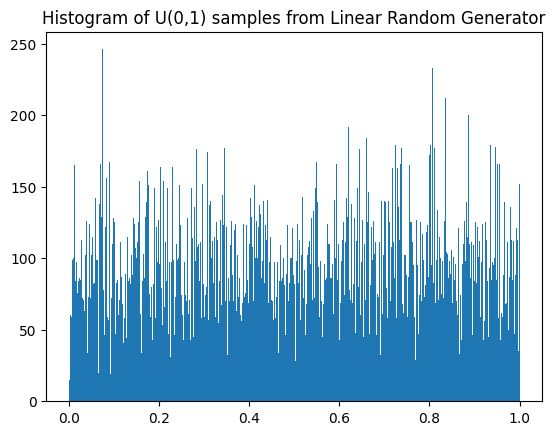

In [5]:
plt.hist(samples_a, bins=1000) 
plt.title('Histogram of U(0,1) samples from Linear Random Generator')
plt.show()

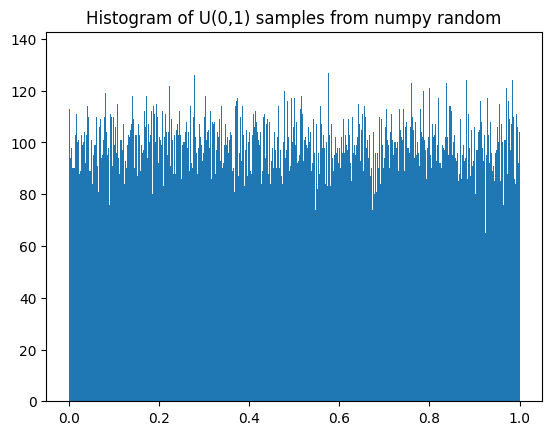

In [6]:
# numpy random widać ze jest lepszy
plt.hist(np.random.rand(N), bins=1000)
plt.title('Histogram of U(0,1) samples from numpy random')
plt.show()

(b) Korzystając z metody eliminacji (lub jej modyfikacji), wygeneruj zmienne losowe z rozkładu o gęstości
f (x) = (1 + cos(2πx) e^(−x^2/2)) / ((1 + e^(−2π^2)) * √(2π)) 

modyfikacja metody eliminacji
Zakładamy, że f (x) ≤ ag(x), gdzie g to gęstość z której umiemy genero-
wać. U nas tym g(x) będzie gęstość rozkłądu normalnego N(0, 1), a a=2

In [7]:
N = 10_000
a = 2
samples_b = np.zeros(N)

def normal_inverse_transform():
    u = lrg.next()
    return stats.norm.ppf(u)  

def pom(x):
    return ((1+math.cos(2 * math.pi * x)) / (1 + math.e ** (-2 * math.pi ** (2)))) #* stats.norm.pdf(x)

for i in range(N):
    while True:
        x = normal_inverse_transform()
        y = lrg.next()
        # if y <= den(x) / stats.norm.pdf(x) * a:
        if y <= pom(x) / a:
            samples_b[i] = x
            break


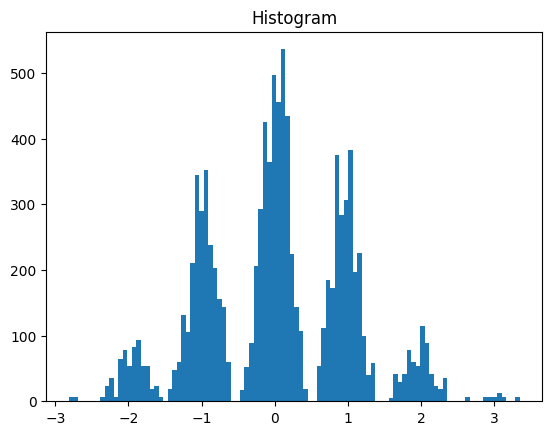

In [8]:
plt.hist(samples_b, bins=100)
plt.title('Histogram')
plt.show()

(c)

sposób 1.

In [9]:
def poisson(lambda_):
    a = lrg.next()
    p_0 = math.exp(-lambda_)
    p = p_0
    i = 0
    while a > p:
        i += 1
        p = p + p_0 * (lambda_ ** i) / math.factorial(i)
    return i

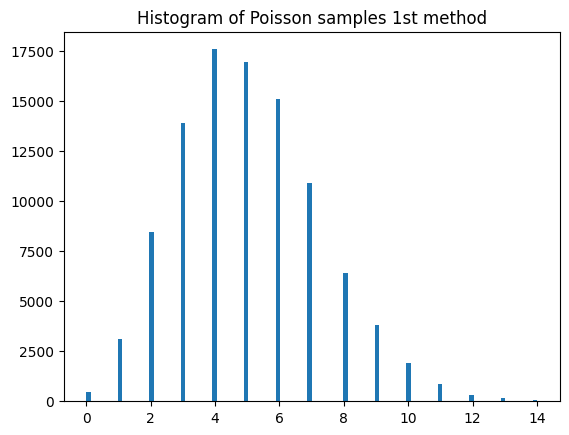

In [10]:
N = 100_000
samples_c1 = np.zeros(N)
lambda_ = 5
for i in range(N):
    n = poisson(lambda_)
    samples_c1[i] = n

plt.hist(samples_c1, bins=100)   
plt.title('Histogram of Poisson samples 1st method')
plt.show()

sposób 2.

In [11]:
def poisson2(lambda_):
    L = math.exp(-lambda_)
    k = 0
    p = 1
    p *= lrg.next()

    while p > L:
        k += 1
        p *= lrg.next()
    return k

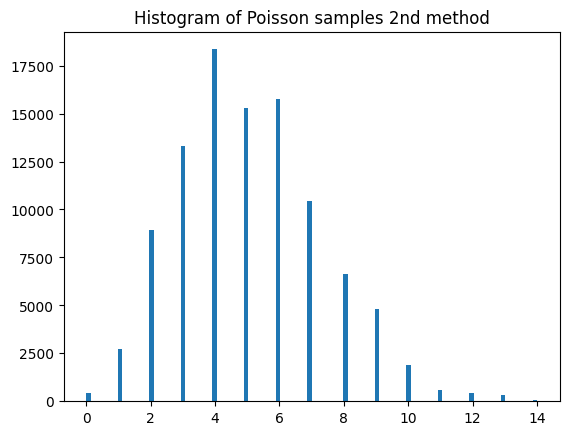

In [12]:
N = 100_000
samples_c2 = np.zeros(N)
lambda_ = 5
for i in range(N):
    n = poisson2(lambda_)
    samples_c2[i] = n

plt.hist(samples_c2, bins=100)
plt.title('Histogram of Poisson samples 2nd method')
plt.show()

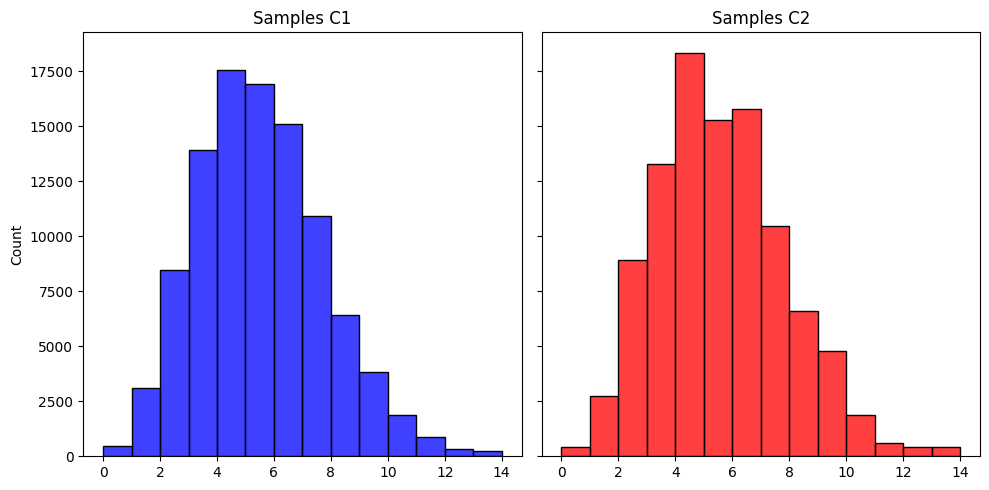

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.histplot(samples_c1, bins=100, binwidth=1, color='blue', ax=axes[0])
axes[0].set_title("Samples C1")

sns.histplot(samples_c2, bins=100, binwidth=1, color='red', ax=axes[1])
axes[1].set_title("Samples C2")

plt.tight_layout()
plt.show()

(c')

In [14]:
def c_prim():
    u = lrg.next()
    print(u)
    if u < 0.5:
        lower_bound_prob = 1/2 - 2/math.pi**2
        i = -1
        while u < lower_bound_prob:
            i -= 1
            lower_bound_prob -= 3/(math.pi**2 * i**2) 
    else:
        upper_bound_prob = 1/2 + 2/math.pi**2
        i = 1
        while u > upper_bound_prob:
            i += 1
            upper_bound_prob += 3/(math.pi**2 * i**2)
    return i

In [15]:
def c_prim(k_max=100):
    u = lrg.next()
    half_p0 = 1/2  # Since p0 = 0, half is initially 1/2
    if u < half_p0:
        lower_bound_prob = half_p0 - 2/math.pi**2
        i = -1
        while u < lower_bound_prob and i > -k_max:
            i -= 1
            lower_bound_prob -= 3/(math.pi**2 * i**2)
    else:
        upper_bound_prob = half_p0 + 2/math.pi**2
        i = 1
        while u > upper_bound_prob and i < k_max:
            i += 1
            upper_bound_prob += 3/(math.pi**2 * i**2)

    return i

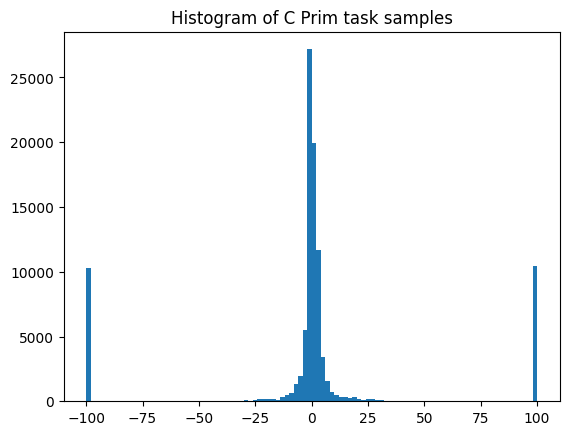

In [16]:
samples_cprim = [c_prim() for _ in range(100_000)]
plt.hist(samples_cprim, bins=100)
plt.title('Histogram of C Prim task samples')
plt.show()

(d)

In [17]:
N = 100_000

# Proporcje rozkładów
probs = [1/3, 1/3, 1/3]

components = np.zeros(N)
for i in range(N):
    u = lrg.next()
    if u < probs[0]:
        components[i] = 0
    elif u < probs[0] + probs[1]:
        components[i] = 1
    else:
        components[i] = 2

def binom_generator(n, p):
    u = lrg.next()
    i = 0
    cdf = stats.binom.cdf(i, n, p)
    while u > cdf:
        i += 1
        cdf += stats.binom.pmf(i, n, p)
    return i

def normal_inverse_transform():
    u = lrg.next()
    return stats.norm.ppf(u)  

def exponential_generator(_lambda):
    u = lrg.next()
    return -np.log(u) / _lambda

In [18]:
samples_d = np.zeros(N)

# Wybieranie odpowiedniego rozkładu dla każdej próbki
samples_d[components == 0] = [binom_generator(10, 1/3) for _ in range(np.sum(components == 0))]
samples_d[components == 1] = [normal_inverse_transform() for _ in range(np.sum(components == 1))]
samples_d[components == 2] = [exponential_generator(1) for _ in range(np.sum(components == 2))]


In [19]:
samples_d = np.sort(samples_d)
ecdf = np.zeros(N)
for i in range(N):
    ecdf[i] = (np.sum(samples_d <= samples_d[i]) / N)

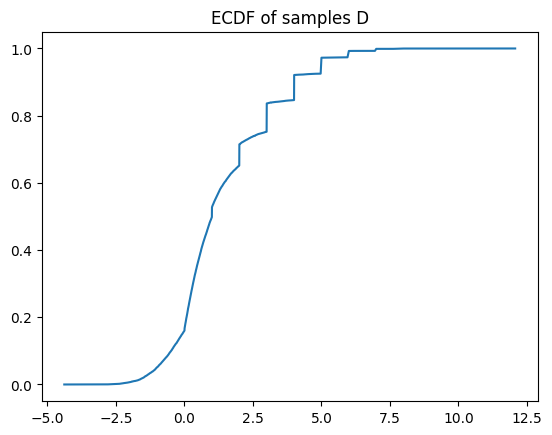

In [20]:
plt.plot(samples_d, ecdf)
plt.title('ECDF of samples D')
plt.show()

In [21]:
x = np.linspace(-4, 12, 100_000)
y = 1/3 * stats.binom.cdf(x, 10, 1/3) + 1/3 * stats.norm.cdf(x) + 1/3 * stats.expon.cdf(x)

Text(0.5, 1.0, 'ECDF and CDF of samples D')

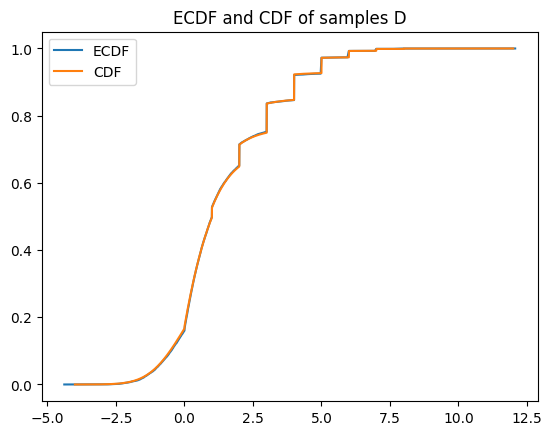

In [22]:
# ECDF and CDF comared
plt.plot(samples_d, ecdf, label='ECDF')
plt.plot(x, y, label='CDF')
plt.legend()
plt.title('ECDF and CDF of samples D')

(e)

In [23]:
z = 362436069
w = 521288629
jsr = 123456789
jcong = 380116160
a = 224466889
b = 7584631
t = []

def znew():
    global z
    z = (36969 * (z & 65535) + (z >> 16)) & 0xFFFFFFFF
    return z

def wnew():
    global w
    w = (18000 * (w & 65535) + (w >> 16)) & 0xFFFFFFFF
    return w

def MWC():
    return ((znew() << 16) + wnew()) & 0xFFFFFFFF

def SHR3():
    global jsr
    jsr ^= (jsr << 17) & 0xFFFFFFFF
    jsr ^= (jsr >> 13) & 0xFFFFFFFF
    jsr ^= (jsr << 5) & 0xFFFFFFFF
    return jsr & 0xFFFFFFFF

def CONG():
    global jcong
    jcong = (69069 * jcong + 1234567) & 0xFFFFFFFF
    return jcong

def KISS():
    return (((MWC() ^ CONG()) + SHR3()) & 0xFFFFFFFF) / 4294967296.0

& 0xFFFFFFFF jest potrzebne (wymusza nam, że wartości będą 32 bitowe), ponieważ w C liczby *unisgned int* mają 32 bity, a gdy liczba zaczyna sie od zera (overflow). Natomiast w Pythonie int nie ma ograniczonej liczby bitów przez co liczby z CONG() i SHR3() rosły w nieskończoność przez co KISS() nie działał poprawnie.

In [24]:
# porównanie szybkości KISS i random.random()
import time
N = 1_000_000
start = time.time()
for i in range(N):
    random.random()
end = time.time()
print("random.random():", end - start)

start = time.time()
for i in range(N):
    KISS()
end = time.time()
print("KISS:", end - start)

random.random(): 0.1376330852508545
KISS: 2.9410970211029053


In [25]:
from numba import jit, uint32

In [26]:
z = 362436069
w = 521288629
jsr = 123456789
jcong = 380116160

@jit(uint32(uint32), nopython=True)
def znew(z):
    z = (36969 * (z & 65535) + (z >> 16)) & 0xFFFFFFFF
    return z

@jit(uint32(uint32), nopython=True)
def wnew(w):
    w = (18000 * (w & 65535) + (w >> 16)) & 0xFFFFFFFF
    return w

@jit(nopython=True)
def MWC(z, w):
    z = znew(z)
    w = wnew(w)
    return ((z << 16) + w) & 0xFFFFFFFF, z, w

@jit(uint32(uint32), nopython=True)
def SHR3(jsr):
    jsr ^= (jsr << 17) & 0xFFFFFFFF
    jsr ^= (jsr >> 13) & 0xFFFFFFFF
    jsr ^= (jsr << 5) & 0xFFFFFFFF
    return jsr

@jit(uint32(uint32), nopython=True)
def CONG(jcong):
    jcong = (69069 * jcong + 1234567) & 0xFFFFFFFF
    return jcong

@jit(nopython=True)
def KISS(z, w, jsr, jcong):
    mwc, z, w = MWC(z, w)
    jsr = SHR3(jsr)
    jcong = CONG(jcong)
    return (((mwc ^ jcong) + jsr) & 0xFFFFFFFF) /4294967296.0, z, w, jsr, jcong

In [27]:
N = 100000

z = 362436069
w = 521288629
jsr = 123456789
jcong = 380116160

start = time.time()
for i in range(N):
    result, z, w, jsr, jcong = KISS(z, w, jsr, jcong)
end = time.time()
print("KISS:", end - start)

KISS: 0.4175755977630615


Cython

In [28]:
from kiss import KISS

start = time.time()
for _ in range(1_000_000):
    KISS()
kiss_time = time.time() - start
print(f"KISS (Cython version) Time: {kiss_time:.5f} seconds")

KISS (Cython version) Time: 0.16738 seconds


In [29]:
# with open("python_rng.bin", "wb") as f:
#     for _ in range(N):
#         f.write(struct.pack("I", random.getrandbits(32)))  

# with open("a_rng.bin", "wb") as f:
#     for _ in range(N):
#         f.write(struct.pack("I", int(lrg.next() * 2**32)))

# with open("kiss_rng.bin", "wb") as f:
#     for _ in range(N):
#         f.write(struct.pack("I", KISS()))  

In [30]:
# dieharder -a -g 201 -f python_rng.bin > dieharder_output.txt